In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [16]:
import cv2
s='1193'

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(4*4*32, 6)
        
    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        out = self.fc(out)
        #print(out.shape)
        return out
        
# Initialize the model
model_frac = CNN()

In [10]:
model_frac=torch.load('model_frac.pkl')

In [11]:
mu=np.load('mu.npy')
sig=np.load('sig.npy')

In [17]:
def pred_pic(s,model_frac):

    # read img
    img = cv2.imread('{}.jpg'.format(s))  
    len_i=img.shape[0]//64
    len_j=img.shape[1]//64  

    # transform and normalization(standarlization)
    XX_img=np.zeros((1, 3, img.shape[0],img.shape[1])).astype(np.float32)
    XX_img[0,0]=(img[:, :, 0]-mu[:,:,0])/sig[:,:,0]
    XX_img[0,1]=(img[:, :, 1]-mu[:,:,0])/sig[:,:,0]
    XX_img[0,2]=(img[:, :, 2]-mu[:,:,0])/sig[:,:,0]

    # break into small pieces
    img_frac=np.zeros((len_i*len_j,3,64,64))
    for i in range (len_i):
        for j in range(len_j):
            img_frac[j+i*len_j]=XX_img[:,:,64*i:64*(i+1),64*j:64*(j+1)]

    # evaluate by model
    model_frac.eval()
    with torch.no_grad():
        images=torch.from_numpy(img_frac).float()
        outputs = model_frac(images)
        _, predicted = torch.max(outputs.data, 1)
        #print(labels,predicted)
        print('total ant count :  ', sum(predicted))

    # show the result
    for i in range(len_i):
        for j in range(len_j):
            cv2.rectangle(img,(j*64, i*64), ((j+1) * 64, (i+1) * 64), (255, 255, 255), 2)
            cv2.putText(img, str(predicted[j+i*len_j].item()), (j*64+30, i*64+30), cv2.FONT_ITALIC, 1, (255, 255, 255), 2)

    plt.imshow(img)

total ant count :   tensor(105)


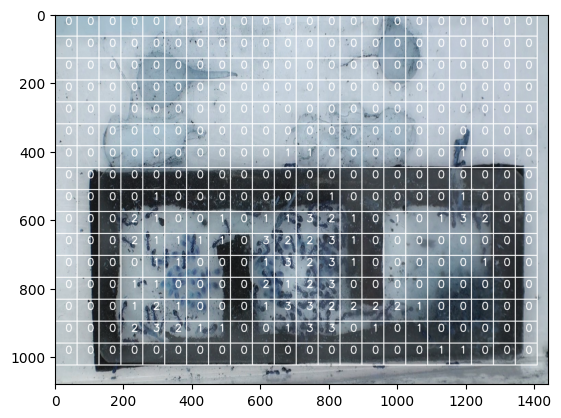

In [18]:
pred_pic(s,model_frac)